In [1]:
import glob
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sys

#accensions and seperations raw data files

accData = 'C:/Users/604070/Desktop/Files/Performance/OPM_HR_Analytics/Model_Development/Data/ACC/ACCDATA_FY2011-2017.TXT'
sepData = 'C:/Users/604070/Desktop/Files/Performance/OPM_HR_Analytics/Model_Development/Data/SEP/SEPDATA_FY2011-2017.TXT'

# reference/dimension tables 

refData = 'C:/Users/604070/Desktop/Files/Performance/OPM_HR_Analytics/Model_Development/Data/REF_Tables/*'


def load_emp_fact():

    '''Load OPM Employment Cube data
       Output: Return processed df of 2018 data'''

    df_total = pd.DataFrame()

    for name in glob.glob(empCube):


        df = pd.read_csv(name,dtype={ 'AGYSUB': str, 'LOC': str, 'AGELVL': str, 'EDLVL': str, 'GSEGRD': str, 'LOSLVL': str, 'OCC': str, 'PATCO': str,
       'PPGRD': str, 'SALLVL': str, 'STEMOCC': str, 'SUPERVIS': str, 'TOA': str, 'WORKSCH': str, 'WORKSTAT': str,
       'DATECODE': str, 'EMPLOYMENT': str, 'SALARY': str, 'LOS': float})    
        df_total = pd.concat([df_total, df])

    #clean salary col cast to integer
    df_total['SALARY'] = df_total['SALARY'].str.replace('$','')
    df_total['SALARY'] = df_total['SALARY'].str.replace(',','')

    df_total = df_total.dropna(axis = 0, how = 'any')

    df_total['SALARY'] = df_total['SALARY'].astype(int)
    
    df_total.drop(['EDLVL', 'EMPLOYMENT', 'STEMOCC', 'SUPERVIS', 'WORKSTAT'], axis = 1 ,inplace = True)
    
    #just 2018 data 
    df_2018 = df_total.loc[df_total['DATECODE'] == '201803']
    
    df_2018_date = df_2018.drop(['DATECODE'], axis =1)
    
    return df_2018_date


def load_acc_fact():

    '''Load accessions data
    
       Output: returns clean dataframe of all accensions data'''

    print('Loading data...')

    df = pd.read_csv(accData, low_memory=False)

    df = df.dropna(axis = 0, how = 'any')

    df['SALARY'] = df['SALARY'].astype(int)
    
    return df    

def load_sep_fact():

    '''Load separations data
    
       Output: returns clean dataframe of all seperations data'''

    df = pd.read_csv(sepData, low_memory=False)

    df = df.dropna(axis = 0, how = 'any')

    df['SALARY'] = df['SALARY'].astype(int)
    
    df = df[df['OCC'] != '****']

    df = df[df['TOA'] != '**']

    return df




def load_dim_table():

    '''load reference tables
    
    Output: returns a list containing dataframes of each reference table '''

    ref_list = []

    for name in glob.glob(refData):

        ref_list.append(pd.read_csv(name))

    return ref_list  



def join_func( df, df_other):
    
    '''Input: two inputs... df a given dataframe ... df_other a given dataframe to be joined to df
       
       Output: Returns a dataframe containing containing both input dataframes '''

    df = df.merge(df_other)

    return df


def joins(df, data):
    
    '''Inputs: df- dataframe to join reference tables; data - flag used to specify which refrence tables to join
    
       Output: Returns dataframe joined to reference tables'''
    
    #indexing based on number and order of reference tables found in the directory

    dim = load_dim_table()

    acc = dim[0]
    age = dim[1]
    agency = dim[2]
    education = dim[4]
    date = dim[5]
    grade = dim[6][1:]
    location = dim[7]
    los = dim[8]
    occ = dim[9]
    patco = dim[10]
    paygroup = dim[11]
    salary = dim[12]
    separation = dim[13]
    stem = dim[14]
    supervisor = dim[15]  
    toa = dim[16]
    workstat = dim[17]
    worksch = dim[18]

    # load fact table 

    df_join = df

    '''reference tables joined to acc/sep fact tables'''  

    if (data == 'accessions'):

        df_join = join_func(df_join, acc)
        
        df_join = join_func(df_join, date)
        
        df_join = join_func(df_join, patco)
    
    elif(data =='separations'):

        df_join = join_func(df_join, separation)
        
        df_join = join_func(df_join, date)
        
        df_join = join_func(df_join, patco)
    
    else:
        
        pass
    

    df_join = join_func(df_join, age)

    df_join = join_func(df_join, agency)    

    df_join = join_func(df_join, location)

    df_join = join_func(df_join, los)

    df_join = join_func(df_join, paygroup)

    df_join = join_func(df_join, salary)

    df_join = join_func(df_join, toa)

    df_join = join_func(df_join, worksch)

    df_join = join_func(df_join, occ)

    return df_join



def join_dim_tables():   

    '''Reduce accension and separation data in star schema to dataframe
    
       Output: returns the accessions and separations data joined to all relevant reference tables'''


    df_joins_acc = joins(load_acc_fact(), 'accessions')

    df_joins_sep = joins(load_sep_fact(), 'separations')


    return df_joins_acc, df_joins_sep  


def raw_data():
    
    '''Load complete accension and separations data '''
    
    acc, sep = join_dim_tables()

    rawData = pd.concat([acc, sep], axis = 0, sort = True)
    
    rawData['EFDATE'] = rawData['EFDATE'].astype(str)

    rawDatalabel = rawData.loc[:,('ACCT','SEPT')]

    rawDatalabel['ACCT'].update(rawDatalabel.pop('SEPT'))
    
    rawDatalabel['ACCT'] = rawDatalabel['ACCT'].apply(lambda x: 1 if x == 'Quit' else 0)
    
    data = pd.concat([rawData, rawDatalabel['ACCT']], axis = 1 )
    
    data.drop(['ACC','LOSLVL','TOATYP','AGELVL','OCCTYP','PPTYP', 'PPTYPT', 'SEPT', 'AGY', 'AGYSUB', 'AGYTYP', 'EFDATE', 'FY', 'LOC', 'LOCTYP', 'OCC', 'OCCFAM','PAYPLAN','PPGROUP','WORKSCH', 'WSTYP','SALLVL','SEP', 'TOA', 'QTR', 'PATCO'  ], axis =1, inplace=True)

    return data


def pre_process():
    
    data = raw_data()
    
    data = data.iloc[:,1:]
    data['Year'] = data['EFDATET'].apply(lambda x: x[4:])
    data['Month'] = data['EFDATET'].apply(lambda x: x[:2])
    data['QTRT'] = data['QTRT'].apply(lambda x: x[:7])
    
    data_dummy = pd.get_dummies(data[['AGELVLT', 'AGYSUBT', 'AGYT', 'AGYTYPT', 'COUNT', 'FYT',
       'GSEGRD', 'LOCT', 'LOCTYPT', 'LOS', 'LOSLVLT', 'OCCFAMT', 'OCCT',
       'OCCTYPT', 'PATCOT', 'PAYPLANT', 'PPGRD', 'PPGROUPT', 'QTRT', 'SALARY',
       'SALLVLT', 'TOAT', 'TOATYPT', 'WORKSCHT', 'WSTYPT', 'ACCT',
       'Year', 'Month']])
    
    whole = pd.concat([data_dummy, data['EFDATET']], axis = 1)
    # 2017 data removed for testing data 
    test_data = whole[whole['Year_2017'] == 1]
    
    train_data = whole[whole['Year_2017'] != 1]
    
    test_data = test_data.drop(['Year_2017'], axis = 1)
    
    train_data = train_data.drop(['Year_2017'], axis = 1)
    
    return train_data, test_data


def normalize(df):
    
    df = df.groupby('EFDATET').sum()
    
    for col in list(df.columns):
       
        mean, std = df[col].mean(), df[col].std()

        df.loc[:, col] = (df[col] -mean) /(std + 1) 
        
    
        
    y = df['ACCT'].reset_index().iloc[:,1]
    
    y = y.values
    
    X = df.drop(['ACCT'], axis = 1).reset_index().iloc[:,1:]
    
    X = X.values
        
    return X, y, df
    
    


In [2]:
# one-hidden - layer fully connected neural network

class deepNet(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        
        self.weights_input_to_hidden = np.random.normal(0, self.input_nodes**-0.5, (self.hidden_nodes, self.input_nodes))
        self.weights_hidden_to_output = np.random.normal(0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.output_nodes))
        
        self.activation = lambda x : 1 /( 1 + np.exp(-x))
            
    def forward_feed(self, inputs):
        
        hidden_inputs = np.dot(inputs, self.weights_input_to_hidden.T)
        
        hidden_outputs = self.activation(hidden_inputs)
        
        # output layer 
        
        inputs_to_output = np.dot(hidden_outputs, self.weights_hidden_to_output.reshape(self.hidden_nodes,1))
                
        output_of_output = self.activation(inputs_to_output)
        
        return hidden_outputs, output_of_output
        
    def back_propagation(self, final_outputs, y, hidden_outputs_1, inputs, weights_change_i_h, weights_change_h_o):
        
        #self, inputs, labels, hidden_outputs, final_outputs, weights_change_i_h, weights_change_h_o
        
        final_outputs = final_outputs.reshape(final_outputs.shape[0],)
        
        error = y - final_outputs
                
        #derivative of error 
        
        error_prime = error * final_outputs * (1 - final_outputs)
        
        hidden_error = np.dot(self.weights_hidden_to_output.reshape(self.hidden_nodes,1), error_prime[:,None].T)
        
        hidden_error_prime = hidden_error.T * (hidden_outputs_1 * (1 - hidden_outputs_1))
        
        weights_change_h_o = np.dot(error_prime[:, None].T, hidden_outputs_1)
        
        weights_change_i_h = np.dot(hidden_error_prime.T, inputs)
                
        return weights_change_i_h, weights_change_h_o
    
    def update_weights(self, weights_change_i_h, weights_change_h_o, n):
        
        self.weights_input_to_hidden += self.learning_rate * weights_change_i_h / n 
        
        self.weights_hidden_to_output += (self.learning_rate * weights_change_h_o / n).reshape(self.hidden_nodes,1)
        
    def train(self, features, targets):
        
        #number of rows in dataset...corresponds to number of months 
        n = features.shape[0]
        
        # initialize weights matrices with zeros 
        weights_change_i_h = np.zeros(self.weights_input_to_hidden.shape)
        weights_change_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        # forward feed 
        hid_outs, fin_outs = self.forward_feed(features)
        
        # backwards_feed 
        
        weights_change_i_h, weights_change_h_o =  self.back_propagation(fin_outs, targets, hid_outs, features, weights_change_i_h, weights_change_h_o)
        
        # update weights 
        
        self.update_weights(weights_change_i_h, weights_change_h_o, n)
        
    def run_model(self, inputs):
        
        hidden_inputs = np.dot(inputs, self.weights_input_to_hidden.T)
        
        hidden_outputs = self.activation(hidden_inputs)
        
        # output Layer 
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        
        final_outputs = self.activation(final_inputs)
        
        return final_outputs
        

In [3]:
# error metric ~ Mean Square Errors 

def meanError(y, Y):
        
        return np.mean((y-Y)**2)

In [4]:
train, test = pre_process()

Loading data...


In [5]:
train_X, train_y, train_normal = normalize(train)

In [6]:
#Parameters
#number of input nodes
#number hidden nodes
#number of output nodes 
#learning rate

#Instantiate model object

model = deepNet(train_X.shape[1],64,1,.001)

In [7]:
#training model 
loss = []

# batch size 
n = 75

# number of training iterations 
cycles = 10000
for i in range(cycles):
    df_X = pd.DataFrame.from_records(train_X)
    batch = np.random.choice(df_X.index, size = n)
    
    model.train(train_X[batch], train_y[batch]) 
    
    output = model.run_model(train_X)
    
    target = train_y[:, None]
    
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * i/float(cycles)) + "% ... Training loss: " + str(meanError(output,target)))
    
    loss.append(meanError(output,target))

Progress: 100.0% ... Training loss: 0.6364112188357733

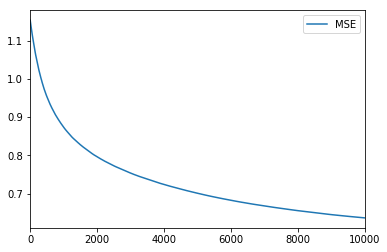

In [8]:
# Mean squared losses on the training data ....
df_loss = pd.DataFrame(loss, columns= ['MSE'])
df_loss.plot()

In [9]:
#Batch sizes 
train_X[batch].shape, train_y[batch].shape

((75, 1425), (75,))

In [10]:
def plot_predictions(df_raw, df_normal, features):
    
    df_original = df_raw.groupby('EFDATET').sum()
    
    mean = df_original.ACCT.mean()
    
    std = df_original.ACCT.std()
    
    actuals = df_normal.ACCT * (std + 1) + mean
    
    predictions = model.run_model(features)
    
    unnormalized_predictions = (predictions * (std + 1) + mean).round()
    
    actuals = actuals.reset_index()
    
    table = pd.concat([actuals, pd.DataFrame(unnormalized_predictions, columns = ['PREDICTIONS'])], axis = 1)
    
    return table 

In [11]:
train_table = plot_predictions(train, train_normal, train_X)

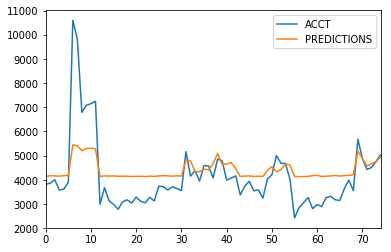

In [12]:
#prediction on the training set should cause overfitting 

train_table[['EFDATET', 'ACCT', 'PREDICTIONS']].plot()

In [13]:
train_table[:6]

,EFDATET,ACCT,PREDICTIONS
0,APR 2011,3815.0,4144.0
1,APR 2012,3861.0,4165.0
2,APR 2013,4006.0,4166.0
3,APR 2014,3576.0,4153.0
4,APR 2015,3616.0,4174.0
5,APR 2016,3898.0,4180.0


In [14]:
test_x, test_y, test_normal = normalize(test)

In [15]:
test_table = plot_predictions(test, test_normal, test_x)

In [16]:
test_table['MONTH'] = pd.DatetimeIndex(test_table['EFDATET']).month

In [17]:
test_table.sort_values(by = ['MONTH'], inplace = True)
test_table

,EFDATET,ACCT,PREDICTIONS,MONTH
3,JAN 2017,4832.0,4805.0,1
2,FEB 2017,3208.0,4490.0,2
6,MAR 2017,3680.0,4486.0,3
0,APR 2017,3688.0,4514.0,4
7,MAY 2017,3900.0,4740.0,5
5,JUN 2017,4371.0,4659.0,6
4,JUL 2017,4491.0,4565.0,7
1,AUG 2017,6939.0,5060.0,8
8,SEP 2017,5124.0,4748.0,9


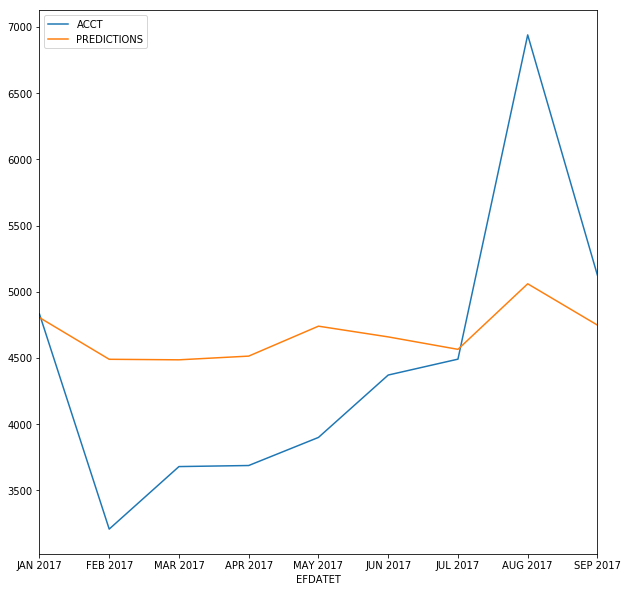

In [18]:
#Predictions of data ~ test data inverval (Jan 2017 - Sep 2017)

ax = plt.gca()
test_table.plot(x = 'EFDATET', y= 'ACCT', figsize=(10,10), ax = ax)
test_table.plot(x = 'EFDATET', y= 'PREDICTIONS', ax = ax)